In [ ]:
! wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -q

In [ ]:
!pip install rembg -q
!pip install Pillow==9.0.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 56.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.23.2 requires pillow>=9.1, but you have pillow 9.0.0 which is incompatible.


- uudelleenajo systeemi epäonnistuneille (ei kasvoja, too big yms)


In [ ]:
import requests
import shutil
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
# from rembg import remove, new_session
from pathlib import Path
from PIL import Image
from datetime import datetime
from io import BytesIO
#from colab import cv2_imshow

ofan_url = "https://www.team-eerola.fi/vlrunner/get_runners_ofan.php"
cascade = "haarcascade_frontalface_default.xml"
datetime.now()

datetime.datetime(2024, 10, 5, 15, 20, 58, 317243)

In [ ]:
latest_run = datetime(2024, 9, 14, 6, 17, 49, 5114)
# latest_run = datetime(2024, 5, 11, 8, 7, 55, 331698)

In [ ]:
def cv2_imshow(img, **kwargs):
  plt.imshow(img[...,::-1])
  for cmd,val in kwargs.items():
    plt_func = getattr(plt,cmd)
    plt_func(val)
  plt.show()

def folder(path: Path) -> str:
    return "-".join(str(path.parent).split("/")[-3:])
u = "https://fanappbucket2022.s3.amazonaws.com/pictures/2023/04/22/_DSC7470.JPG"

In [ ]:
u = Path(u)
folder(Path(u)), u.name

('2023-04-22', '_DSC7470.JPG')

In [ ]:
! rm cached_runners.txt

rm: cannot remove 'cached_runners.txt': No such file or directory


In [ ]:
def get_runners(n=None,start=None):
    """async version below is FAST"""
    default_team = 'https://fanappbucket2022.s3.eu-north-1.amazonaws.com/team_pictures/default_team.jpg'
    cache = "cached_runners.txt"
    target_img_size = 3e5 # pixels

    if os.path.exists(cache):
        print("reading from cache:",cache)
        with open(cache,'r') as f:
            res = f.read()
    else:
        print("request to", ofan_url)
        res = requests.get(ofan_url)
        res = res.text.rstrip()
        with open(cache,'w') as f:
            f.write(res)
        print("cached to", cache)

    rows = res.split("\n")[1:]
    if n:
        random.shuffle(rows)
    else:
        n = len(rows) - (start if start else 0)
    if start:
        rows = rows[start:]
    for i, row in enumerate(rows[:n]):
        row = row.split(";")
        name, photo_url = row[3], row[6]
        if photo_url != "" and photo_url != default_team:
            img = requests.head(photo_url)
            last_mod = img.headers["Last-Modified"]
            dt = datetime.strptime(last_mod, "%a, %d %b %Y %H:%M:%S %Z")
            print(f"{i+1}/{n}",end="\r")
            if dt > latest_run:
                print(f"{i+1}/{n} new image",photo_url)
                img = get_photo(photo_url, target_img_size)
                yield photo_url, img


def get_photo(url: str, ts: int = 3e5, downsample: bool = True) -> Image.Image:
    res = requests.get(url)
    img = Image.open(BytesIO(res.content))
    if not downsample:
        return img

    h,w = img.size
    r = round((h*w / ts)**0.5)
    if r>1:
        print(f"{(h, w)}->{(h//r, w//r)}, {r=}, {h//r * w//r} pixels")
        img = img.resize((h//r, w//r))
    return img


In [ ]:
import asyncio
import aiohttp

async def latest_modification_later_than(photo_url, latest_run, session):
    async with session.head(photo_url) as resp:
        last_mod = resp.headers["Last-Modified"]
        dt = datetime.strptime(last_mod, "%a, %d %b %Y %H:%M:%S %Z")
        if dt > latest_run:
            return photo_url

async def get_new(photo_urls, latest_run):
    print(f"making {len(photo_urls)} request to s3 asynchronously")
    async with aiohttp.ClientSession(raise_for_status=True) as session:
        results = await asyncio.gather(*[
            latest_modification_later_than(
                url, latest_run, session) for url in photo_urls])
    return [r for r in results if r is not None]

In [ ]:
#latest_run = datetime(2020, 8, 25, 0, 0, 0, 0)
async def get_runners_async(n=None, start=None, latest_run=datetime(2000,1,1)):
    default_team = 'https://fanappbucket2022.s3.eu-north-1.amazonaws.com/team_pictures/default_team.jpg'
    cache = "cached_runners.txt"

    if os.path.exists(cache):
        print("reading from cache:",cache)
        with open(cache,'r') as f:
            res = f.read()
    else:
        print("request to", ofan_url)
        res = requests.get(ofan_url)
        res = res.text.rstrip()
        with open(cache,'w') as f:
            f.write(res)
        print("cached to", cache)

    rows = res.split("\n")[1:]
    if n:
        random.shuffle(rows)
    else:
        n = len(rows) - (start if start else 0)
    if start:
        rows = rows[start:]
    rows = rows[:n]
    photo_urls = [i.split(";")[6] for i in rows]
    photo_urls = [j for j in photo_urls if j != "" and j != default_team]
    new_rows = await get_new(photo_urls, latest_run)
    return new_rows


In [ ]:
latest_run

datetime.datetime(2024, 9, 14, 6, 17, 49, 5114)

In [ ]:
# to check that are there any new ones
photo_g = await get_runners_async(latest_run=latest_run)
len(photo_g)

request to https://www.team-eerola.fi/vlrunner/get_runners_ofan.php
cached to cached_runners.txt
making 599 request to s3 asynchronously


0

In [ ]:
list(photo_g)

[]

In [ ]:
iknv = [
    "https://fanappbucket2022.s3.amazonaws.com/pictures/2023/04/20/Tuomas_Heikkil%C3%A4_.jpg",
    "https://fanappbucket2022.s3.amazonaws.com/thumb_pictures/2022/07/02/Veli_Kangas_.jpg"
]
# iknv = [(Path(i),get_photo(i)) for i in iknv]
# iknv


In [ ]:
def detect_face(img,faceCascade,size_limit=.1):
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    # detect with confidence
    faces,_,c = faceCascade.detectMultiScale3(
        gray,
        scaleFactor=1.15, # 1.1-1.2
        minNeighbors=4, # 4 or 5
        outputRejectLevels=True)
    if len(faces)>0:
        sort_i = np.argsort(-c)
        faces = faces[sort_i]
        for x, y, fw, fh in faces:
            #print(fw/img.shape[0],fh/img.shape[1])
            if fw/img.shape[0]>size_limit and fh/img.shape[1]>size_limit:
                return [(x, y, fw, fh)]
    return []


def resize_and_pad(img,face,th,tw,width_scale=2.2,h_scale=0.3):
    h, w = img.shape[:2]
    x, y, fw, fh = face
    s = th/tw
    dw = int(fw*width_scale)
    dh = int(s*dw)
    dx = int(x+fw/2*(1-width_scale))
    dy = int(y-fh*h_scale)
    if dx+dw > w or dy+dh > h or dx<0 or dy<0:
        #print(h,w)
        #print(dx+dw,dx,dy+dw,w)
        BLACK = [0,0,0]
        img_pad = cv2.copyMakeBorder(img,
            top=max(-dy,0)+max(dy+dh-h,0),
            bottom=0,
            left=max(-dx,0),
            right=max(dx+dw-w,0),
            borderType=cv2.BORDER_CONSTANT,
            value=BLACK)

        img_pad = img_pad[max(0,dy):dy+dh if dy+dh<h else -1 , max(dx,0):dx+dw if dx+dw<w else -1]
    else:
        img_pad = img[dy:dy+dh , dx:dx+dw]
    return cv2.resize(img_pad,(tw,th))

def resize_and_crop(img,face,th,tw,width_scale=2.2,h_scale=0.3):
    h,w = img.shape[:2]
    x, y, fw, fh = face
    #cv2.rectangle(img, (x, y), (x+fw, y+fh), (255, 0, 0), 2)
   # cv2_imshow(img)
    s = th/tw
    dw = int(fw*width_scale)
    dh = int(s*dw)
    dx = int(x+fw/2*(1-width_scale))
    dy = int(y-fh*h_scale)
    #print(dx,dy,dw,dh)
    #cv2.rectangle(img,(dx,dy),(dx+dw,dy+dh),(0, 200, 255),2)
    #cv2_imshow(img)
    if dx+dw > w or dy+dh > h or dx<0 or dy<0:
        if width_scale > 1.0:
          width_scale-=0.04
          h_scale-=0.02
          if h_scale<0:
            # can stuck in infinite recursion and fail??
            return []
        print(f"retrying with {width_scale=} {h_scale=}")
        return resize_and_crop(img,face,th,tw,width_scale,h_scale)

    img_crop = img[dy:dy+dh , dx:dx+dw]
    return cv2.resize(img_crop,(tw,th))

0/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/05/04/IMG_6588.heic
HEIC FILE! NOT SUPPORTED
1/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/04/12/Miina.jpg
(1457, 2048)->(485, 682), r=3, 331093 pixels


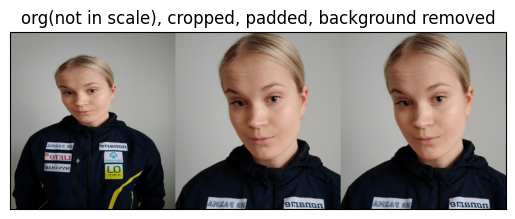

2/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/05/04/IMG_6589.heic
HEIC FILE! NOT SUPPORTED
3/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/05/04/DSC03708.jpg
(716, 972)->(358, 486), r=2, 173988 pixels


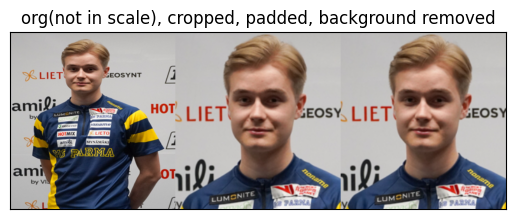

4/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/05/04/DSC03703.jpg
(749, 1069)->(374, 534), r=2, 199903 pixels


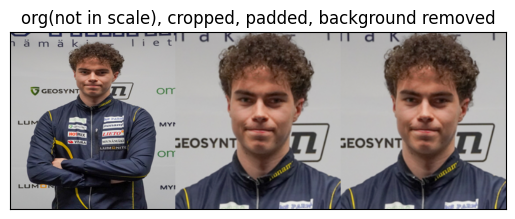

5/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/05/04/DSC03742.jpg


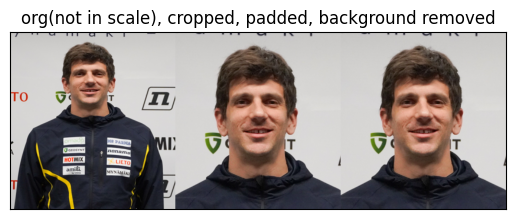

6/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/05/04/DSC03752.jpg
(697, 1013)->(348, 506), r=2, 176262 pixels


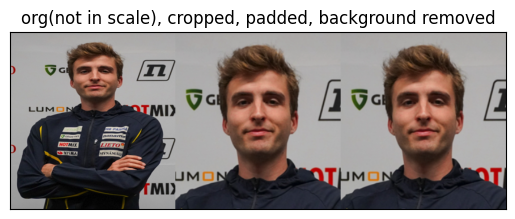

7/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/05/04/DSC03720.jpg


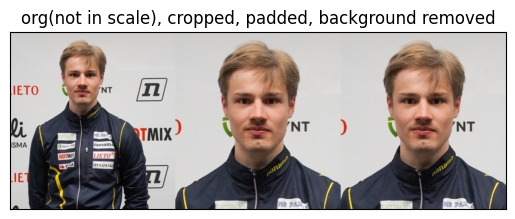

8/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/05/04/DSC03734.jpg
(794, 1044)->(397, 522), r=2, 207234 pixels


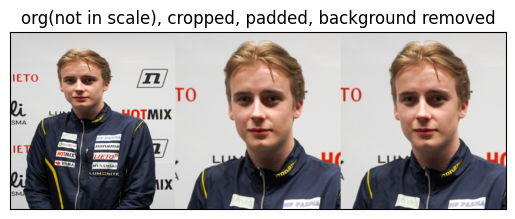

9/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/04/26/Vieda_Lusa.jpeg
(3456, 5184)->(432, 648), r=8, 279936 pixels


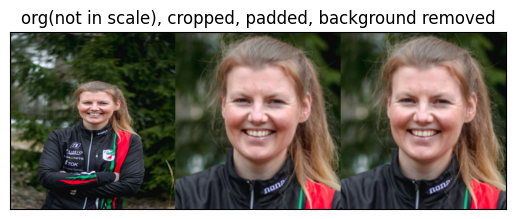

10/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/04/26/Henna_Yliluikki.jpg
(853, 1280)->(426, 640), r=2, 272640 pixels


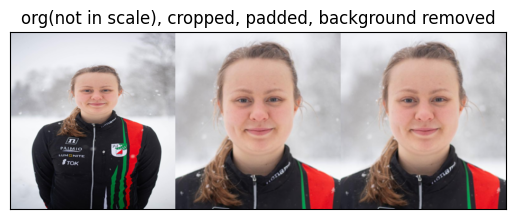

11/27, https://fanappbucket2022.s3.amazonaws.com/pictures/2024/05/31/Eveliina_Hirvonen.jpg
(4480, 6720)->(448, 672), r=10, 301056 pixels


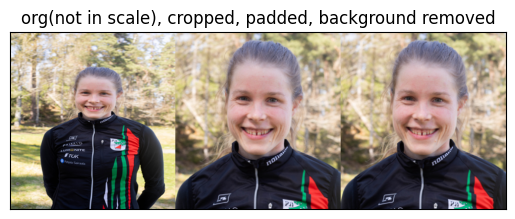

In [ ]:
#img_stats = 300,260,2.2,0.4 # face+upper body
# img_stats = 300,300,1.7,0.4 # face
img_stats = 300,280,1.9,0.4 # new setup
target_img_size = 3e5 # pixels
faceCascade = cv2.CascadeClassifier(cascade)
result_folder = Path("drive")/"MyDrive"/"VL"
#result_folder = Path(".") # local
# (result_folder/"bg").mkdir(parents=True, exist_ok=True)
(result_folder/"crop").mkdir(parents=True, exist_ok=True)
# session = new_session(model_name="u2net_human_seg")
# photo_g = await get_runners_async(latest_run=latest_run)
show=True
save=True
nface=[]
for i, imgurl in enumerate(photo_g[15:]):
    print(f"{i}/{len(photo_g)}, {imgurl}")
    if imgurl.endswith(".heic"):
        print("HEIC FILE! NOT SUPPORTED")
        continue
    img_o = get_photo(imgurl, target_img_size, downsample=True)
    img = cv2.cvtColor(np.array(img_o), cv2.COLOR_RGB2BGR)

    #spinning the image if face not found
    for _ in range(3):
        faces = detect_face(img, faceCascade, .05)
        if len(faces) > 0:
            face = faces[0] # is there confidence in match? if yes select highest
            break
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        print("rotating")

    if len(faces) == 0:
        print("NOT FOUND FACE",imgurl)
        nface.append(imgurl)
        continue
    #face = np.array([151,  38,  70,  70])
    prosed_padded = resize_and_pad(img, face, *img_stats)

    prosed_img = resize_and_crop(img, face, *img_stats)
    if len(prosed_img) == 0:
        print("face too big!", imgurl)
        prosed_img = np.zeros_like(prosed_padded)


    # out = remove(prosed_padded, session=session)
    if show:
        org = np.array(img_o.resize(img_stats[1::-1]))[...,:3][...,::-1]
        cv2_imshow(
            np.concatenate((org,prosed_img,prosed_padded),axis=1),
            # np.concatenate((org,prosed_img,prosed_padded,out[:,:,:-1]),axis=1),
        title="org(not in scale), cropped, padded, background removed", xticks=[], yticks=[])

    if save:
        imgpath = Path(imgurl)
        fol = folder(imgpath)

        if imgpath.suffix in [".jfif"]:
            # save as jpg, rename to jfif
            asjpg = result_folder/"crop"/(fol+(imgpath.stem+".jpg"))
            cv2.imwrite(str(asjpg), prosed_img)
            (asjpg).rename(result_folder/"crop"/(fol+(imgpath.stem+".jfif")))
        else:
            cv2.imwrite(str(result_folder/"crop"/(fol+imgpath.name)), prosed_img)
            # cv2.imwrite(str(result_folder/"bg"/(fol+(imgpath.stem+".png"))), out)


In [ ]:
! grep -i teemu cached_runners.txt

6;Angelniemen Ankkuri;AngA.png;Teemu Kerkola;;;https://fanappbucket2022.s3.amazonaws.com/pictures/2024/04/06/teemuk.jpg
145;Ikaalisten Nouseva-Voima;IkNV.png;Teemu Oksanen;;;https://fanappbucket2022.s3.amazonaws.com/pictures/2023/05/23/Teemu_Oksanen.jpg


In [ ]:
default_team = 'https://fanappbucket2022.s3.eu-north-1.amazonaws.com/team_pictures/default_team.jpg'
cache = "cached_runners.txt"
target_img_size = 3e5 # pixels

if os.path.exists(cache):
    print("reading from cache:",cache)
    with open(cache,'r') as f:
        res = f.read()
else:
    print("request to", ofan_url)
    res = requests.get(ofan_url)
    res = res.text.rstrip()
    with open(cache,'w') as f:
        f.write(res)
    print("cached to", cache)

rows = res.split("\n")[1:]
no_crop=[]
no_bg=[]
for i, row in enumerate(rows):
    row = row.split(";")
    name, photo_url = row[3], row[6]
    print(name)
    u = Path(photo_url)
    fname = folder(u)+u.name
    if not os.path.exists(f"drive/MyDrive/VL/crop/{folder(u)}{u.name}"):
        no_crop.append(photo_url)
        print("No crop photo for", photo_url)
    if not os.path.exists(f"drive/MyDrive/VL/bg/{folder(u)}{u.stem}.png"):
        no_bg.append(photo_url)
        print("No bg photo for", photo_url)

In [ ]:
nface

[]

In [ ]:
ng =  [(f, get_photo(f)) for f in nface]

(1080, 1350)->(540, 675), r=2, 364500 pixels


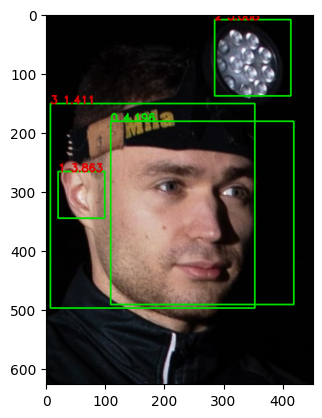

In [ ]:
# img_pil='https://fanappbucket2022.s3.amazonaws.com/thumb_pictures/2022/07/02/Marttiina_Joensuu_3.jpg'
# img_pil=get_photo(img_pil)
faceCascade = cv2.CascadeClassifier(cascade)
url, img_pil = ng[1]
img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
size_limit=.05
# Detect faces
faces,_,c = faceCascade.detectMultiScale3(gray, 1.01, 3,outputRejectLevels=True)# 4 or 5
sort_i = np.argsort(-c)
faces = faces[sort_i]
c = c[sort_i]
for i,((x, y, fw, fh),conf) in enumerate((zip(faces,c))):
    #print(fw/img.shape[0],fh/img.shape[1])
    if fw/img.shape[0]>size_limit and fh/img.shape[1]>size_limit:
        cv2.rectangle(img, (x,y), (x+fw,y+fh), [0,225,0], 2)
        cv2.putText(img, f"{i} {conf:.3f}", (x,y), cv2.FONT_HERSHEY_SIMPLEX, .6,
                 [0,225,0] if conf>4. else [0,0,225],2)
    else:
        cv2.rectangle(img, (x,y), (x+fw,y+fh), [225,0,0], 2)
        cv2.putText(img, f"{i} {conf:.3f}", (x,y), cv2.FONT_HERSHEY_SIMPLEX, .6,
                 [225,0,0] if conf>4. else [0,0,225] ,2)

cv2_imshow(img)

In [ ]:
from google.colab import drive
drive.mount('/content/drive_real')

Mounted at /content/drive_real


In [ ]:
!cd drive_real

In [ ]:
!cp drive/MyDrive/VL/* drive_real/MyDrive/VL/ -r

In [ ]:
no_photo = """
2024-04-11Eevert.JPG
2024-04-09Anna.png
2024-03-13Danny2.jpeg
2024-04-10thumbnail_IMG_8574.jpg
2024-04-07Emmi_Ofan.png
2024-03-13ynnic.jpeg
2024-03-13tappi.jpg
2024-03-13saulite2.jpeg
2024-03-13Russe2.jpeg
2024-03-13hatm.jpeg
2024-03-13Glebi.jpg
2024-03-13akseli2.jpeg
2023-05-014443DC1F-AE27-4777-91F2-0AB0E59D9D37.jpeg
2023-05-01suvi.jpg
2023-04-20Olli_Tiainen.jpg
""".split()
# https://fanappbucket2022.s3.amazonaws.com/pictures/2024/04/26/Henna_Yliluikki.jpg
nop = [f"https://fanappbucket2022.s3.amazonaws.com/pictures/{s[:4]}/{s[5:7]}/{s[8:10]}/{s[10:]}" for s in no_photo]
photos = [get_photo(i) for i in nop]

In [ ]:
for n,pp in zip(no_photo,photos):
    pp.save("nophotos/"+n)

In [ ]:
!zip -r nophoto.zip nophotos

  adding: nophotos/ (stored 0%)
  adding: nophotos/2024-04-09Anna.png (deflated 0%)
  adding: nophotos/2024-03-13Glebi.jpg (deflated 0%)
  adding: nophotos/2024-04-11Eevert.JPG (deflated 0%)
  adding: nophotos/2023-05-01suvi.jpg (deflated 0%)
  adding: nophotos/2023-04-20Olli_Tiainen.jpg (deflated 1%)
  adding: nophotos/2023-05-014443DC1F-AE27-4777-91F2-0AB0E59D9D37.jpeg (deflated 0%)
  adding: nophotos/2024-04-10thumbnail_IMG_8574.jpg (deflated 0%)
  adding: nophotos/2024-03-13tappi.jpg (deflated 1%)
  adding: nophotos/2024-03-13saulite2.jpeg (deflated 1%)
  adding: nophotos/2024-03-13hatm.jpeg (deflated 1%)
  adding: nophotos/2024-03-13Russe2.jpeg (deflated 0%)
  adding: nophotos/2024-04-07Emmi_Ofan.png (deflated 0%)
  adding: nophotos/2024-03-13akseli2.jpeg (deflated 4%)
  adding: nophotos/2024-03-13ynnic.jpeg (deflated 1%)
  adding: nophotos/2024-03-13Danny2.jpeg (deflated 4%)
